In [1]:
# Suppress warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import IsolationForest

# Load and show the dataset from the specified path
df = pd.read_csv("D:\file cleaned.csv", header=0)
df.head()

,ID,DEFAULT,CARDHLDR,SPENDING,AGE,ACADMOS,ADEPCNT,MAJORDRG,MINORDRG,OWNRENT,SELFEMPL,ANNUAL_INCOME,MTH_SINCE_APP,AGE_AT_APP
0,528199,0,1,103,22,122,1,0,0,0,0,17000,29,20
1,989446,0,1,95,24,6,4,0,1,0,1,20799,32,22
2,687594,0,1,117,47,48,1,0,0,1,0,50400,21,46
3,996978,0,1,56,38,14,2,0,0,1,0,23240,16,37
4,881043,0,0,226,29,36,0,5,1,0,0,27999,28,27


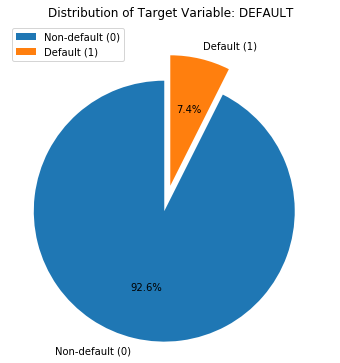

In [2]:
# Distribution of the Target Variable (DEFAULT)
default_counts = df['DEFAULT'].value_counts()
explode = (0.2, 0)  # "explode" to highlight the "default" segment

# Create a pie chart for the distribution of the target variable 'DEFAULT'
plt.figure(figsize=(8, 6))
plt.pie(default_counts, labels=['Non-default (0)', 'Default (1)'],
        autopct='%1.1f%%', startangle=90, explode=explode)
plt.title('Distribution of Target Variable: DEFAULT')
plt.legend(labels=['Non-default (0)', 'Default (1)'], loc='upper left', frameon=True)
plt.show()

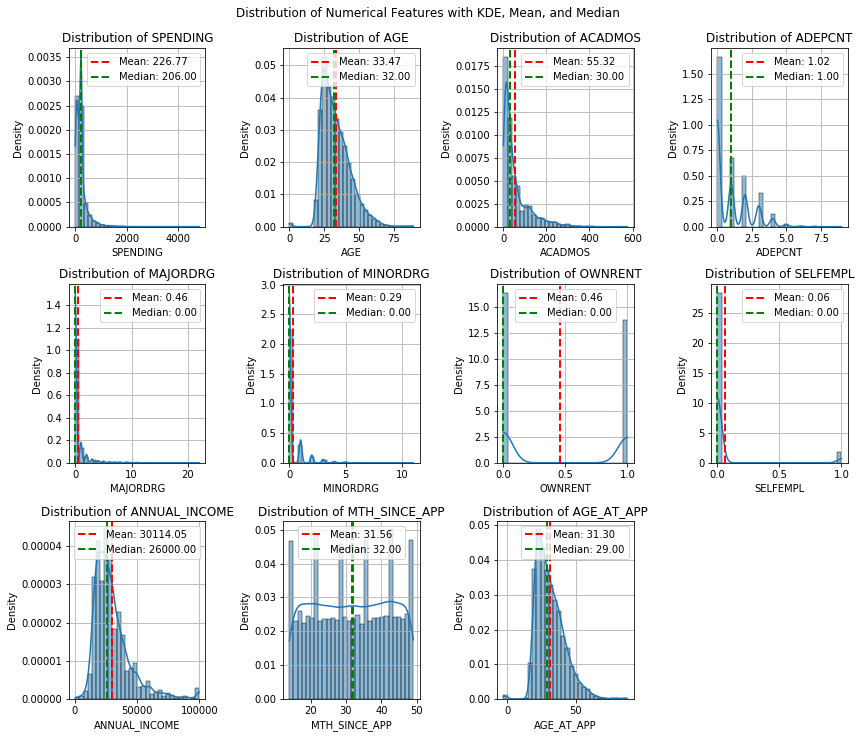

In [3]:
# List of numerical features
numerical_columns = numerical_columns = ['SPENDING', 'AGE', 'ACADMOS', 'ADEPCNT', 'MAJORDRG', 'MINORDRG', 'OWNRENT', 
                                         'SELFEMPL', 'ANNUAL_INCOME', 'MTH_SINCE_APP', 'AGE_AT_APP']

plt.figure(figsize=(12, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 4, i)  # Adjusted the subplot grid to 3 rows and 3 columns
    sns.histplot(df[column], kde=True, bins=30, stat='density')
    
    mean_val = df[column].mean()
    median_val = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend(loc='best')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Distribution of Numerical Features with KDE, Mean, and Median', y=1.02)
plt.show()

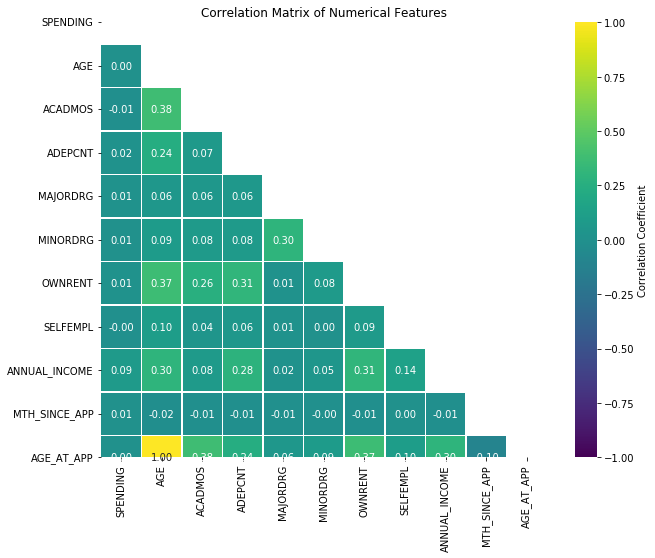

In [4]:
# heatmap for correlation matrix
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))

# Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, mask=mask, 
            vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [5]:
# Drop the 'AGE_AT_APP' column as it's perfectly correlated with 'AGE'
df.drop(columns=['AGE_AT_APP'], inplace=True)

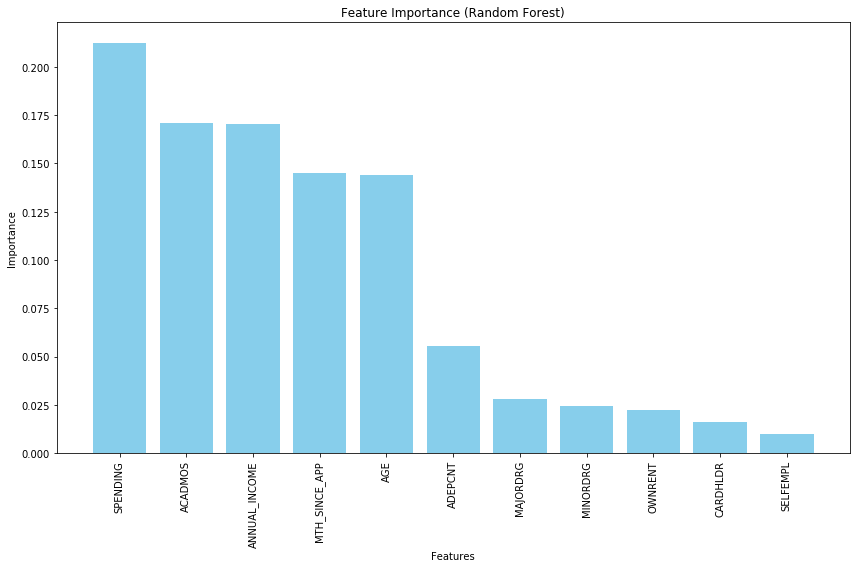

In [6]:
# Feature Importance Plot by Random Forest

# Define the target and features
X = df.drop(columns=['DEFAULT','ID'])  # Drop the target variable
y = df['DEFAULT']  # The target variable (default/no default)

# Initialize and train the Random Forest model
model = RandomForestClassifier(random_state=123)  # Adding random_state for reproducibility
model.fit(X, y)

# Get feature importances from the trained model
importances = model.feature_importances_

# Sort the features by importance (highest to lowest)
indices = np.argsort(importances)[::-1]

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(X.shape[1]), importances[indices], align='center', color='skyblue')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [7]:
# Display feature names and their importance scores in a table
feature_importance_df = pd.DataFrame({
    'Feature': X.columns[indices],
    'Importance': importances[indices]
})

feature_importance_df

,Feature,Importance
0,SPENDING,0.212411
1,ACADMOS,0.170829
2,ANNUAL_INCOME,0.170658
3,MTH_SINCE_APP,0.144915
4,AGE,0.143919
5,ADEPCNT,0.055489
6,MAJORDRG,0.028364
7,MINORDRG,0.024636
8,OWNRENT,0.022362
9,CARDHLDR,0.016391


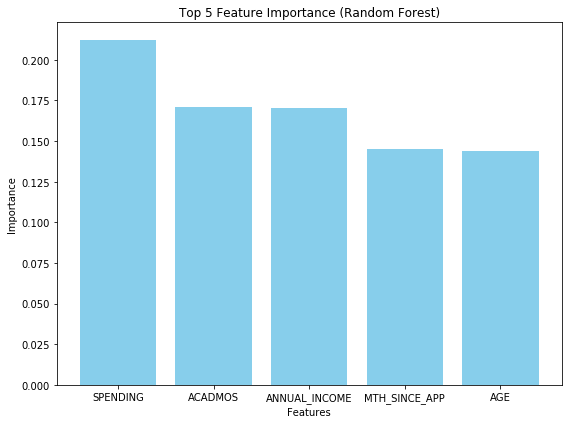

Top 5 Important Features:
Index(['SPENDING', 'ACADMOS', 'ANNUAL_INCOME', 'MTH_SINCE_APP', 'AGE'], dtype='object')


In [15]:
# Choosing top 5 features based on the importance 
top_5_indices = indices[:5]  # Select the top 5 features
top_5_features = X.columns[top_5_indices]

# Plot feature importances for the top 5 features
plt.figure(figsize=(8, 6))
plt.title('Top 5 Feature Importance (Random Forest)')
plt.bar(range(5), importances[top_5_indices], align='center', color='skyblue')  # Adjust to top 5
plt.xticks(range(5), top_5_features, rotation=0)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Display the list of top 5 features
print("Top 5 Important Features:")
print(top_5_features)  # Display the list of top 5 features

In [8]:
# selecting the top 5 features using Chi-squared Test 

X = df.drop(columns=['DEFAULT','ID'])  # Drop the target variable
y = df['DEFAULT']  # The target variable (default/no default)

X_encoded = X.copy()

# Use SelectKBest with chi2 test to select the top 5 features
selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(X_encoded, y)
cols_idxs = selector.get_support(indices=True)

# Select columns based on indices and display the top 5 features
X_selected = X_encoded.iloc[:, cols_idxs]

# Display the top 15 selected features
print("Top 5 Selected Features:")
print(X_selected.columns.tolist())

# Show the first few rows of the new feature set
X_selected.head()

Top 5 Selected Features:
['CARDHLDR', 'SPENDING', 'ACADMOS', 'MAJORDRG', 'ANNUAL_INCOME']


,CARDHLDR,SPENDING,ACADMOS,MAJORDRG,ANNUAL_INCOME
0,1,103,122,0,17000
1,1,95,6,0,20799
2,1,117,48,0,50400
3,1,56,14,0,23240
4,0,226,36,5,27999


In [16]:
# Cpmparision of the Chi-squared test & Random Forest
lstX2 = X_selected.columns.tolist()
lstRandFors = list(top_5_features)

# Convert lists to sets for easy comparison
setX2 = set(lstX2)
setRandFors = set(lstRandFors)

# Identify common elements (features present in both lists)
common_features = setX2.intersection(setRandFors)

# Identify unique elements (features only in lstX2 but not in lstRandFors)
unique_to_X2 = setX2.difference(setRandFors)

# Identify unique elements (features only in lstRandFors but not in lstX2)
unique_to_RandFors = setRandFors.difference(setX2)

# Print the results
print("Common Features:")
print(common_features)

print("\nFeatures Unique to X_selected:")
print(unique_to_X2)

print("\nFeatures Unique to Top 5 Features (Random Forest):")
print(unique_to_RandFors)

# Optional: Count the number of common and unique features
print(f"\nNumber of common features: {len(common_features)}")
print(f"Number of features unique to X_selected: {len(unique_to_X2)}")
print(f"Number of features unique to Top 5 Features: {len(unique_to_RandFors)}")

Common Features:
{'ACADMOS', 'SPENDING', 'ANNUAL_INCOME'}

Features Unique to X_selected:
{'MAJORDRG', 'CARDHLDR'}

Features Unique to Top 5 Features (Random Forest):
{'AGE', 'MTH_SINCE_APP'}

Number of common features: 3
Number of features unique to X_selected: 2
Number of features unique to Top 5 Features: 2


In [17]:
# the union of the features
union_features = setX2.union(setRandFors)
union_features_list = list(union_features)

print(f"Union of Features (Selected by either Chi-squared or Random Forest): \n {union_features_list}")

Union of Features (Selected by either Chi-squared or Random Forest): 
 ['ACADMOS', 'MAJORDRG', 'AGE', 'SPENDING', 'CARDHLDR', 'ANNUAL_INCOME', 'MTH_SINCE_APP']


In [18]:
# Modify the df to keep only the top features based on Chi-squared or Random Forest Test
df = pd.concat([df[union_features_list], y], axis=1)

print("\nModified DataFrame (Top 7 Features and Target 'DEFAULT'):")
df.head()


Modified DataFrame (Top 7 Features and Target 'DEFAULT'):


,ACADMOS,MAJORDRG,AGE,SPENDING,CARDHLDR,ANNUAL_INCOME,MTH_SINCE_APP,DEFAULT
0,122,0,22,103,1,17000,29,0
1,6,0,24,95,1,20799,32,0
2,48,0,47,117,1,50400,21,0
3,14,0,38,56,1,23240,16,0
4,36,5,29,226,0,27999,28,0


In [19]:
# Save the DataFrame to a CSV file, excluding the index column
file_path = 'D:\file processed.csv'
df.to_csv(file_path, index=False) 

 1    13309
-1      135
Name: anomaly, dtype: int64


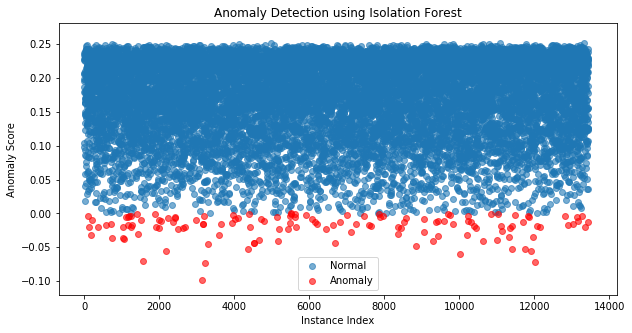

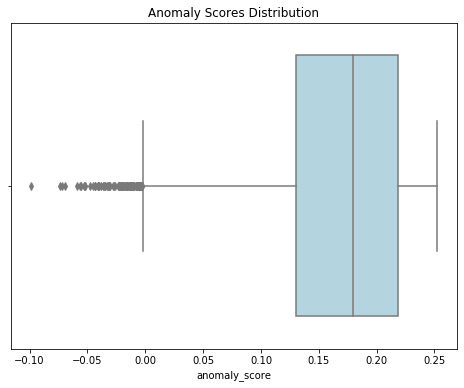

In [20]:
# anomaly detection using the Isolation Forest 

n_estimators = 100  # Number of trees in the forest
contamination = 0.01  # Expected proportion of outliers
sample_size = 256  # Number of samples to train each tree

features = df.select_dtypes(include=[np.number])  
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=sample_size,
                            random_state=123)
iso_forest.fit(features)

# Calculate anomaly scores and classify anomalies
df['anomaly_score'] = iso_forest.decision_function(features)  # Calculate anomaly score
df['anomaly'] = iso_forest.predict(features)  # Predict anomalies (1 for normal, -1 for anomaly)

# Check how many anomalies and normal instances
print(df['anomaly'].value_counts())

# Visualization of the results
plt.figure(figsize=(10, 5))

normal = df[df['anomaly'] == 1]  
plt.scatter(normal.index, normal['anomaly_score'], label='Normal', alpha=0.6)

anomalies = df[df['anomaly'] == -1]  
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='red', alpha=0.6)

plt.xlabel("Instance Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Detection using Isolation Forest")
plt.legend()
plt.show()

# Box plot to better visualize the distribution of anomaly scores
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['anomaly_score'], color='lightblue')
plt.title('Anomaly Scores Distribution')
plt.show()


The anomalies appear to be valid and may represent significant rare events, such as fraud or exceptional cases of loan defaults, and should therefore be retained

In [21]:
df.head()

,ACADMOS,MAJORDRG,AGE,SPENDING,CARDHLDR,ANNUAL_INCOME,MTH_SINCE_APP,DEFAULT,anomaly_score,anomaly
0,122,0,22,103,1,17000,29,0,0.196188,1
1,6,0,24,95,1,20799,32,0,0.236662,1
2,48,0,47,117,1,50400,21,0,0.198638,1
3,14,0,38,56,1,23240,16,0,0.206782,1
4,36,5,29,226,0,27999,28,0,0.104672,1


In [22]:
from collections import Counter

anomalies = df[df['anomaly'] == -1]
dict(Counter(anomalies['DEFAULT']))

{1: 43, 0: 92}

In [23]:
# Save the DataFrame to a CSV file, excluding the index column
file_path = 'D:\file processed anomaly.csv'

df.to_csv(file_path, index=False) 